In [150]:
%load_ext autoreload
%autoreload 2

from pathlib import Path

import pandas as pd
import shap
from flaml import AutoML
from xgboost import XGBClassifier

from util import engineer_features, prep_X_y

DATA_DIR = Path("./pistachio_1_data")
dyads_df = pd.read_csv(DATA_DIR / "all_dyads.csv")

sorted_dyads_df = dyads_df.sort_values(
    by="ActivityDateTime", key=lambda x: pd.to_datetime(x)
)
cleaned_dyads_dfs = engineer_features(
    sorted_dyads_df,
    stress_lookback_days=0,
    sleep_days_to_keep=[1, 2],
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/var/folders/gv/lj5cf4w14fqc6937ndlg7qb40000gr/T/ipykernel_25092/176410518.py:14: DtypeWarning: Columns (95,124,125,126,127,128) have mixed types. Specify dtype option on import or set low_memory=False.
  dyads_df = pd.read_csv(DATA_DIR / "all_dyads.csv")
/Users/zhu.henian/projects/pistachio/util.py:150: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(df["ActivityDateTime"]) - pd.to_datetime(df["Therapy Start"])


In [183]:
import numpy as np
from sklearn.metrics import roc_auc_score

week_range = (0, 15)
active_hours = (7, 20)

supersets_to_test = [
    ["watch"],
    ["watch", "demographic"],
    ["watch", "medical"],
    ["watch", "demographic", "medical"],
]
feature_supersets = {
    "watch": [
        "hr",
        "activity",
        "sleep",
        "stress",
        "overnight_hrv",
    ],
    "demographic": [
        "child_demo",
        "parent_demo",
    ],
    "medical": [
        "medical",
        "therapy",
    ],
}


def bootstrap(df: pd.DataFrame, n_samples: int) -> pd.DataFrame:
    boot_df = pd.DataFrame()
    for _ in range(n_samples):
        boot_df = pd.concat(
            [
                boot_df,
                df.sample(frac=1, replace=True, random_state=None),
            ]
        )
    return boot_df


def population_model_shap(supersets: list[str]) -> shap.Explanation:
    df = pd.concat(
        [
            cleaned_dyads_dfs["index"],
            cleaned_dyads_dfs["response"],
        ]
        + [
            cleaned_dyads_dfs[fs]
            for superset in supersets
            for fs in feature_supersets[superset]
        ],
        axis=1,
    )
    df = df[df["therapy_week"].between(week_range[0], week_range[1])]
    df = df[df["ActivityDateTime"].dt.hour.between(active_hours[0], active_hours[1])]

    df_train = df[df["Arm_Sham"]]
    df_test = df[~df["Arm_Sham"]]

    groups = df_train["dyad"]
    automl_settings = {
        "max_iter": 100,
        "estimator_list": ["xgboost"],
        "early_stop": True,
        "eval_method": "cv",
        "split_type": "group",
        "groups": groups,
        "retrain_full": False,
        "verbose": 0,
    }

    window = "60m"
    X_train, y_train = prep_X_y(df_train, f"tantrum_within_{window}")
    X_test, y_test = prep_X_y(df_test, response_column=f"tantrum_within_{window}")

    automl = AutoML()
    automl.fit(
        X_train=X_train,
        y_train=y_train,
        **automl_settings,
    )
    model = XGBClassifier(**automl.best_config)
    model.fit(X_train, y_train)
    print("Best config:", automl.best_config)

    # Predict probabilities for the positive class
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    # Compute ROC AUC
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    print(f"ROC AUC: {roc_auc:.4f}")

    # Create SHAP explainer
    explainer = shap.Explainer(model)
    shap_values = explainer(X_test)
    return shap_values


def individual_model_shap(supersets: list[str], week: int) -> shap.Explanation:
    df = pd.concat(
        [
            cleaned_dyads_dfs["index"],
            cleaned_dyads_dfs["response"],
        ]
        + [
            cleaned_dyads_dfs[fs]
            for superset in supersets
            for fs in feature_supersets[superset]
        ],
        axis=1,
    )
    df = df[df["therapy_week"].between(week_range[0], week_range[1])]
    df = df[df["ActivityDateTime"].dt.hour.between(active_hours[0], active_hours[1])]

    df_sham = df[df["Arm_Sham"]]
    df_active = df[~df["Arm_Sham"]]

    automl = AutoML()
    automl_settings = {
        "max_iter": 100,
        "estimator_list": ["xgboost"],
        "eval_method": "cv",
        "split_type": "group",
        "groups": df_sham["dyad"],
        "verbose": 0,
        "retrain_full": False,
    }
    X_train_init, y_train_init = prep_X_y(df_sham, "tantrum_within_60m")
    automl.fit(
        X_train=X_train_init,
        y_train=y_train_init,
        **automl_settings,
    )
    print("Best config:", automl.best_config)

    all_shaps = []
    all_features = []
    base_values = []

    all_proba = []
    all_trues = []

    for dyad, dyad_df in df_active.groupby("dyad"):
        add_df = dyad_df[dyad_df["therapy_week"] < week]
        add_df = bootstrap(add_df, df_active["dyad"].nunique())

        df_train = pd.concat([df_sham, add_df])
        df_test = dyad_df[dyad_df["therapy_week"] == week]

        window = "60m"
        X_train, y_train = prep_X_y(df_train, f"tantrum_within_{window}")
        X_test, y_test = prep_X_y(df_test, response_column=f"tantrum_within_{window}")

        # Skip if only one class present or no data past that week
        if not len(df_test) or y_test.nunique() < 2:
            continue

        model = XGBClassifier(**automl.best_config)
        model.fit(X_train, y_train)

        # # Compute ROC AUC
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        all_proba.extend(y_pred_proba)
        all_trues.extend(y_test)

        # Create SHAP explainer
        explainer = shap.Explainer(model)
        sv = explainer(X_test)
        all_shaps.append(sv.values)  # The SHAP values
        all_features.append(sv.data)  # The actual feature values
        base_values.append(sv.base_values)  # The starting point (expected value)

    # aggregated_shaps = np.vstack(all_shaps)
    # aggregated_features = np.vstack(all_features)
    # aggregated_base = np.concatenate(base_values)

    auroc = roc_auc_score(all_trues, all_proba)
    print(f"AUROC: {auroc}")

    aggregated_shaps = np.vstack(all_shaps)
    aggregated_features = np.vstack(all_features)
    aggregated_base = np.concatenate(base_values)

    print(aggregated_shaps.shape)

    exp = shap.Explanation(
        values=aggregated_shaps,
        data=aggregated_features,
        base_values=aggregated_base,
        feature_names=X_train_init.columns.tolist(),
    )
    return exp

Best config: {'n_estimators': 4, 'max_leaves': 197, 'min_child_weight': np.float64(0.08835624807789765), 'learning_rate': np.float64(0.06712968018607121), 'subsample': np.float64(0.7360889411438515), 'colsample_bylevel': np.float64(0.5407062422549573), 'colsample_bytree': 1.0, 'reg_alpha': 0.0009765625, 'reg_lambda': np.float64(0.29582636054466854)}
AUROC: 0.7326935081148565
(1128, 54)


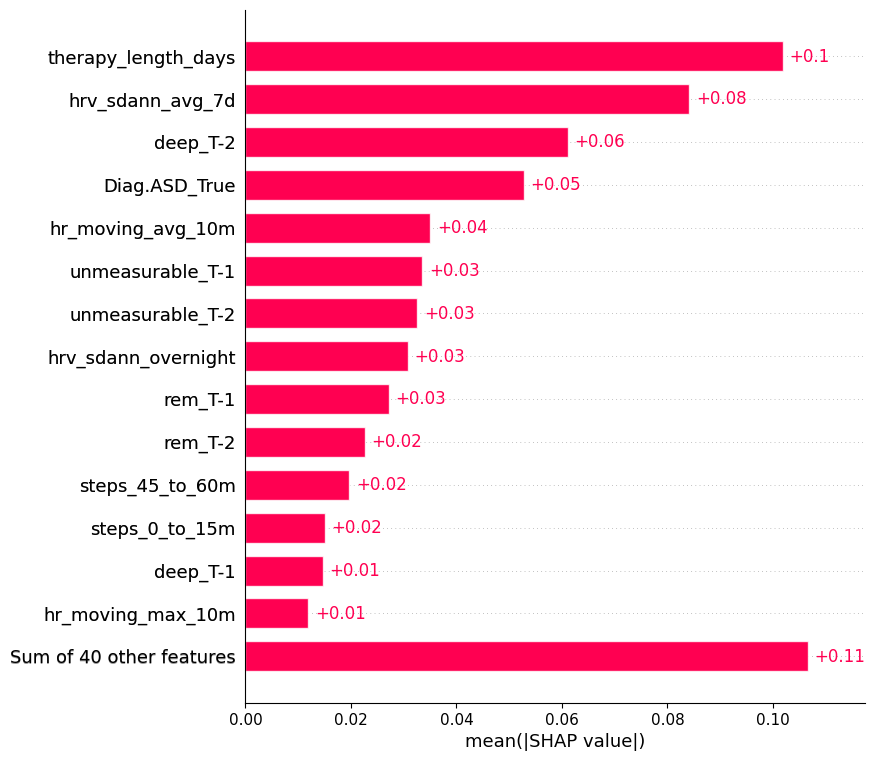

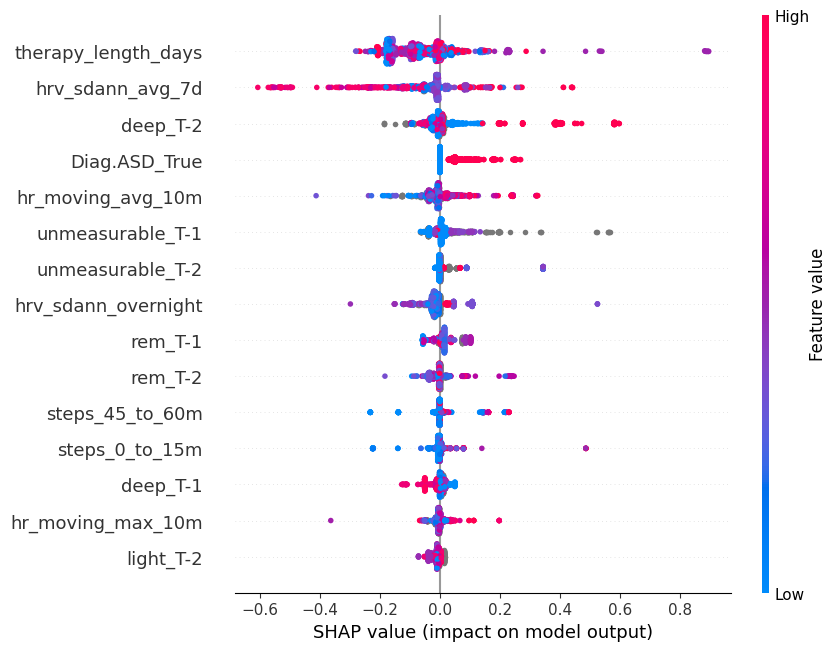

In [194]:
explanation = individual_model_shap(supersets_to_test[-1], week=15)
shap.plots.bar(explanation, max_display=15)
shap.plots.beeswarm(explanation, group_remaining_features=False, max_display=15)